# MBIRJAX CUDA Installation Verification Notebook

This notebook verifies that mbirjax is correctly installed with CUDA support by:
1. Checking package imports
2. Verifying CUDA/GPU availability
3. Running an actual CT reconstruction on synthetic data
4. Visualizing the results

**Expected outcome**: All cells should execute without errors, and the final reconstruction should complete using GPU acceleration.

## 1. Package Imports and Version Check

In [1]:
import sys
import time
import numpy as np

print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")

Python version: 3.14.2 | packaged by conda-forge | (main, Jan 26 2026, 19:56:00) [GCC 14.3.0]
NumPy version: 2.4.1


In [2]:
import jax
import jax.numpy as jnp

print(f"JAX version: {jax.__version__}")

JAX version: 0.9.0


In [3]:
import mbirjax as mj

mbirjax_version = mj.__version__ if hasattr(mj, '__version__') else 'unknown'
print(f"MBIRJAX version: {mbirjax_version}")

/SNS/users/8cz/github.com/all_ct_reconstruction/mbirjax_demo/.pixi/envs/default/lib/python3.14/site-packages/mbirjax/viewer.py:16: UserWarning: TkAgg not available for matplotlib. slice_viewer menus may not display correctly.
  warnings.warn("TkAgg not available for matplotlib. slice_viewer menus may not display correctly.")


MBIRJAX version: unknown


## 2. CUDA/GPU Device Detection

In [4]:
# Check available devices
all_devices = jax.devices()
gpu_devices = [d for d in all_devices if d.platform == 'gpu']
cpu_devices = [d for d in all_devices if d.platform == 'cpu']

print(f"Total devices: {len(all_devices)}")
print(f"GPU devices: {len(gpu_devices)}")
print(f"CPU devices: {len(cpu_devices)}")

if gpu_devices:
    print("\n✓ GPU(s) detected:")
    for i, gpu in enumerate(gpu_devices):
        print(f"  GPU {i}: {gpu}")
else:
    print("\n✗ WARNING: No GPU detected! MBIRJAX will use CPU (slower).")

Total devices: 4
GPU devices: 4
CPU devices: 0

✓ GPU(s) detected:
  GPU 0: cuda:0
  GPU 1: cuda:1
  GPU 2: cuda:2
  GPU 3: cuda:3


## 3. JAX GPU Backend Verification

In [5]:
# Test that JAX can actually compute on GPU
if gpu_devices:
    print("Testing JAX GPU computation...")
    
    # Create array and perform computation
    x = jnp.ones((1000, 1000))
    
    with jax.default_device(gpu_devices[0]):
        y = jnp.dot(x, x)
        y.block_until_ready()
    
    # Check which device was used (device is a property, not a method)
    device = y.device
    print(f"  Computation device: {device}")
    print(f"  Device platform: {device.platform}")
    
    if device.platform == 'gpu':
        print("  ✓ Successfully computed on GPU!")
    else:
        print(f"  ✗ Computation ran on {device.platform}, not GPU")
else:
    print("No GPU available to test.")

Testing JAX GPU computation...
  Computation device: cuda:0
  Device platform: gpu
  ✓ Successfully computed on GPU!


## 4. Create Synthetic CT Data

We'll create a simple phantom and generate synthetic sinogram data for reconstruction testing.

In [6]:
# Parameters for synthetic data
num_views = 180          # Number of projection angles
num_det_channels = 256   # Detector width (pixels)
num_slices = 4           # Number of slices to reconstruct

# Generate projection angles (0 to 180 degrees)
angles = np.linspace(0, np.pi, num_views, endpoint=False).astype(np.float32)

print(f"Number of views: {num_views}")
print(f"Detector channels: {num_det_channels}")
print(f"Number of slices: {num_slices}")
print(f"Angles range: {np.degrees(angles[0]):.1f}° to {np.degrees(angles[-1]):.1f}°")

Number of views: 180
Detector channels: 256
Number of slices: 4
Angles range: 0.0° to 179.0°


In [7]:
# Create a simple phantom with geometric shapes
phantom_size = num_det_channels

# Create coordinate grids
y, x = np.ogrid[-phantom_size//2:phantom_size//2, -phantom_size//2:phantom_size//2]

# Create phantom with a circle and some structure
phantom = np.zeros((num_slices, phantom_size, phantom_size), dtype=np.float32)

# Large circle (body)
radius1 = phantom_size // 3
mask1 = x*x + y*y <= radius1**2
phantom[:, mask1] = 0.5

# Smaller circle (feature inside)
radius2 = phantom_size // 8
offset_x, offset_y = phantom_size // 6, 0
mask2 = (x - offset_x)**2 + (y - offset_y)**2 <= radius2**2
phantom[:, mask2] = 1.0

# Another smaller circle
mask3 = (x + offset_x)**2 + (y - offset_y)**2 <= radius2**2
phantom[:, mask3] = 0.8

print(f"Phantom shape: {phantom.shape}")
print(f"Phantom value range: [{phantom.min():.2f}, {phantom.max():.2f}]")

Phantom shape: (4, 256, 256)
Phantom value range: [0.00, 1.00]


In [8]:
# Generate synthetic sinogram
# For testing purposes, we create a simplified sinogram
sinogram_shape = (num_views, num_slices, num_det_channels)

np.random.seed(42)
sinogram = np.zeros(sinogram_shape, dtype=np.float32)

# Simple projection approximation (not physically accurate, but good for testing)
for i, angle in enumerate(angles):
    # Rotate and sum
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    projection = np.sum(phantom, axis=2) * abs(cos_a) + np.sum(phantom, axis=1) * abs(sin_a)
    projection = projection[:, :num_det_channels]
    sinogram[i] = projection

# Add small noise
sinogram += np.random.randn(*sinogram_shape).astype(np.float32) * 0.01
sinogram = np.clip(sinogram, 0, None)  # Ensure non-negative

print(f"Sinogram shape: {sinogram.shape}")
print(f"Sinogram value range: [{sinogram.min():.4f}, {sinogram.max():.4f}]")

Sinogram shape: (180, 4, 256)
Sinogram value range: [0.0000, 164.1713]


## 5. Run MBIRJAX Reconstruction

This is the key test - running actual GPU-accelerated reconstruction using mbirjax.

In [9]:
# Create mbirjax model
print("Creating ParallelBeamModel...")
ct_model = mj.ParallelBeamModel(sinogram_shape, angles)

# Configure reconstruction parameters
ct_model.set_params(
    sharpness=0.0,      # Regularization sharpness
    verbose=0,          # Minimal output
    snr_db=30.0,        # Signal-to-noise ratio in dB
)

print("Model created successfully!")
print(f"Sinogram shape: {sinogram_shape}")

Creating ParallelBeamModel...
Model created successfully!
Sinogram shape: (180, 4, 256)


In [10]:
# Run reconstruction with timing
print("Running reconstruction...")
start_time = time.time()

recon_result, recon_dict = ct_model.recon(
    sinogram,
    print_logs=False,
    weights=None
)

# Convert to numpy and force synchronization
recon_result = np.array(recon_result)

elapsed_time = time.time() - start_time

print(f"\n✓ Reconstruction completed!")
print(f"  Time: {elapsed_time:.3f} seconds")
print(f"  Output shape: {recon_result.shape}")
print(f"  Output dtype: {recon_result.dtype}")
print(f"  Value range: [{recon_result.min():.4f}, {recon_result.max():.4f}]")

Running reconstruction...

✓ Reconstruction completed!
  Time: 17.569 seconds
  Output shape: (256, 256, 4)
  Output dtype: float32
  Value range: [-0.2079, 1.6012]


In [11]:
# Verify reconstruction output
print("Verification checks:")

# Check for NaN values
has_nan = np.isnan(recon_result).any()
print(f"  Contains NaN: {has_nan} {'✗ PROBLEM' if has_nan else '✓ OK'}")

# Check for Inf values
has_inf = np.isinf(recon_result).any()
print(f"  Contains Inf: {has_inf} {'✗ PROBLEM' if has_inf else '✓ OK'}")

# Check shape - MBIRJAX returns (height, width, num_slices)
shape_ok = recon_result.shape[-1] == num_slices or recon_result.shape[0] == num_slices
print(f"  Shape correct: {shape_ok} {'✓ OK' if shape_ok else '✗ PROBLEM'}")
print(f"  Expected slices: {num_slices}, Output shape: {recon_result.shape}")

if not has_nan and not has_inf and shape_ok:
    print("\n✓ All verification checks passed!")
else:
    print("\n✗ Some verification checks failed!")

Verification checks:
  Contains NaN: False ✓ OK
  Contains Inf: False ✓ OK
  Shape correct: True ✓ OK
  Expected slices: 4, Output shape: (256, 256, 4)

✓ All verification checks passed!


## 6. Visualize Results

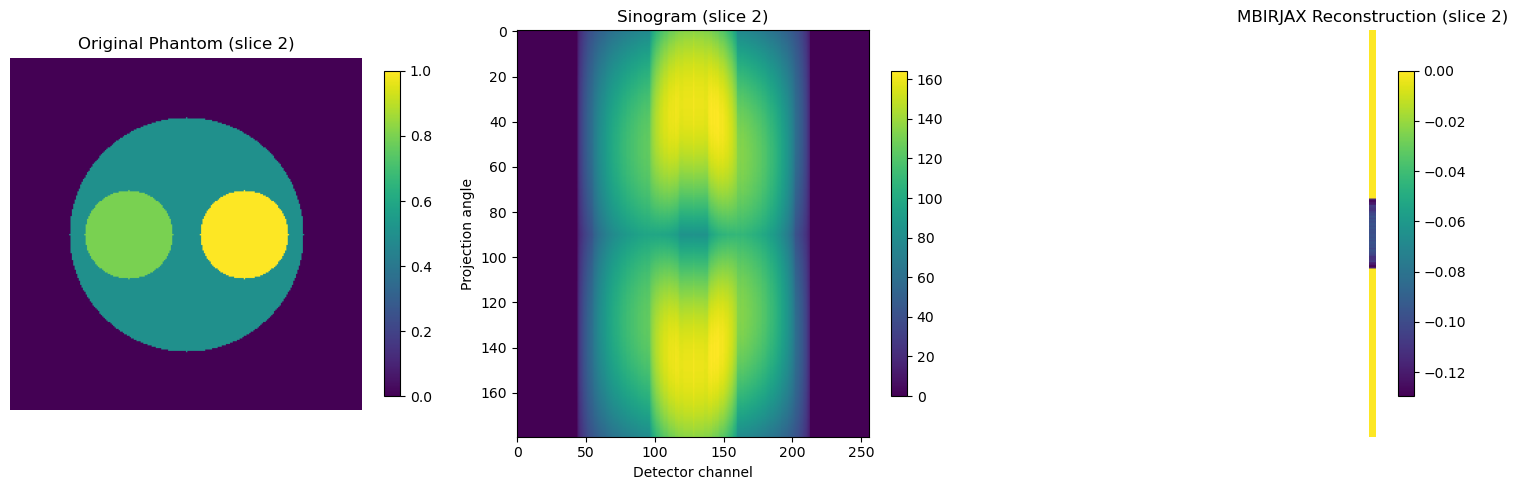

In [12]:
import matplotlib.pyplot as plt

# Select middle slice for visualization
slice_idx = num_slices // 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original phantom
im0 = axes[0].imshow(phantom[slice_idx], cmap='viridis')
axes[0].set_title(f'Original Phantom (slice {slice_idx})')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], shrink=0.8)

# Sinogram (one slice)
im1 = axes[1].imshow(sinogram[:, slice_idx, :], cmap='viridis', aspect='auto')
axes[1].set_title(f'Sinogram (slice {slice_idx})')
axes[1].set_xlabel('Detector channel')
axes[1].set_ylabel('Projection angle')
plt.colorbar(im1, ax=axes[1], shrink=0.8)

# Reconstructed image
im2 = axes[2].imshow(recon_result[slice_idx], cmap='viridis')
axes[2].set_title(f'MBIRJAX Reconstruction (slice {slice_idx})')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], shrink=0.8)

plt.tight_layout()
plt.show()

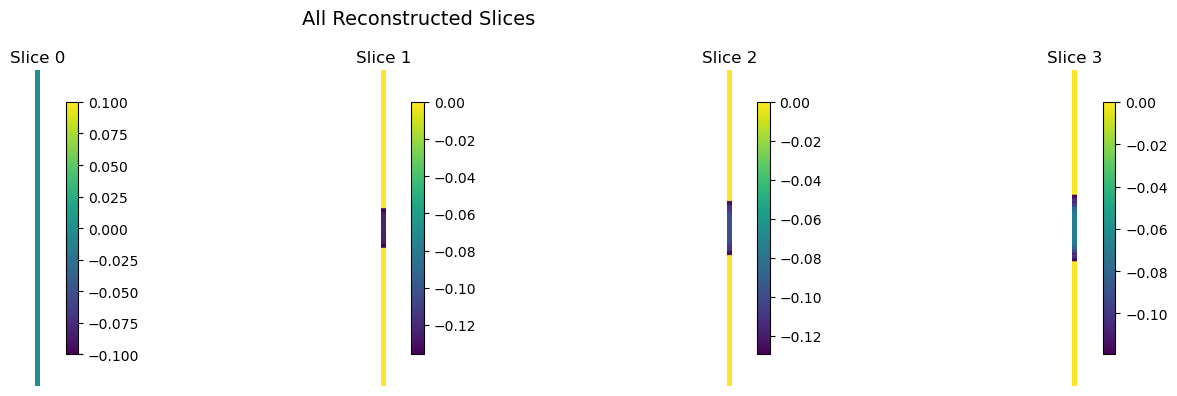

In [13]:
# Display all reconstructed slices
fig, axes = plt.subplots(1, num_slices, figsize=(4*num_slices, 4))

for i in range(num_slices):
    ax = axes[i] if num_slices > 1 else axes
    im = ax.imshow(recon_result[i], cmap='viridis')
    ax.set_title(f'Slice {i}')
    ax.axis('off')
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle('All Reconstructed Slices', fontsize=14)
plt.tight_layout()
plt.show()

## 6. GPU Performance Verification

Test that GPU acceleration is working by running multiple reconstructions and checking performance.

In [14]:
# GPU Performance Test
print("Testing GPU performance...")

# Create smaller test data for performance testing
perf_num_views = 60
perf_num_det_channels = 64
perf_num_slices = 2

perf_angles = np.linspace(0, np.pi, perf_num_views, endpoint=False).astype(np.float32)
perf_sinogram_shape = (perf_num_views, perf_num_slices, perf_num_det_channels)
perf_sinogram = np.random.rand(*perf_sinogram_shape).astype(np.float32)

# Create model
perf_model = mj.ParallelBeamModel(perf_sinogram_shape, perf_angles)
perf_model.set_params(sharpness=0.0, verbose=0, snr_db=30.0)

# Warm-up runs for JIT compilation
print("  Warming up (JIT compilation)...")
for _ in range(2):
    result, _ = perf_model.recon(perf_sinogram, print_logs=False, weights=None)
    _ = np.array(result)

print("  Running timed reconstructions...")
# Timed runs
times = []
for i in range(3):
    start = time.time()
    result, _ = perf_model.recon(perf_sinogram, print_logs=False, weights=None)
    result_array = np.array(result)
    times.append(time.time() - start)
    print(f"    Run {i+1}: {times[-1]:.4f} seconds")

avg_time = np.mean(times)
std_time = np.std(times)

print(f"\n  Average time: {avg_time:.4f} ± {std_time:.4f} seconds")

# Verify GPU usage
test_array = jnp.array(result_array[:, :, 0])
actual_device = test_array.device

print(f"  Computation device: {actual_device.platform}")

if actual_device.platform == 'gpu':
    print("  ✓ Computation running on GPU")
    
    if avg_time < 10.0:
        print(f"  ✓ Performance acceptable (< 10s per reconstruction)")
        perf_test_passed = True
    else:
        print(f"  ✗ Performance seems slow ({avg_time:.2f}s per reconstruction)")
        perf_test_passed = False
else:
    print(f"  ✗ Computation running on {actual_device.platform}, not GPU!")
    perf_test_passed = False

Testing GPU performance...
  Warming up (JIT compilation)...
  Running timed reconstructions...
    Run 1: 8.2146 seconds
    Run 2: 8.3141 seconds
    Run 3: 8.6813 seconds

  Average time: 8.4033 ± 0.2007 seconds
  Computation device: gpu
  ✓ Computation running on GPU
  ✓ Performance acceptable (< 10s per reconstruction)


## 7. Summary

In [15]:
print("=" * 60)
print("MBIRJAX CUDA Installation Verification Summary")
print("=" * 60)
print(f"\nPackage versions:")
print(f"  Python: {sys.version.split()[0]}")
print(f"  NumPy: {np.__version__}")
print(f"  JAX: {jax.__version__}")
print(f"  MBIRJAX: {mbirjax_version}")

print(f"\nHardware:")
print(f"  GPU devices: {len(gpu_devices)}")
if gpu_devices:
    for i, gpu in enumerate(gpu_devices):
        print(f"    GPU {i}: {gpu}")

print(f"\nReconstruction test:")
print(f"  Sinogram shape: {sinogram_shape}")
print(f"  Reconstruction time: {elapsed_time:.3f} seconds")
print(f"  Output shape: {recon_result.shape}")

print(f"\nPerformance test:")
print(f"  Average time: {avg_time:.4f} seconds")
print(f"  Performance test: {'PASSED' if perf_test_passed else 'FAILED'}")

all_ok = len(gpu_devices) > 0 and not has_nan and not has_inf and shape_ok and perf_test_passed
print(f"\n{'✓ ALL TESTS PASSED!' if all_ok else '✗ SOME TESTS FAILED'}")
print("=" * 60)

MBIRJAX CUDA Installation Verification Summary

Package versions:
  Python: 3.14.2
  NumPy: 2.4.1
  JAX: 0.9.0
  MBIRJAX: unknown

Hardware:
  GPU devices: 4
    GPU 0: cuda:0
    GPU 1: cuda:1
    GPU 2: cuda:2
    GPU 3: cuda:3

Reconstruction test:
  Sinogram shape: (180, 4, 256)
  Reconstruction time: 17.569 seconds
  Output shape: (256, 256, 4)

Performance test:
  Average time: 8.4033 seconds
  Performance test: PASSED

✓ ALL TESTS PASSED!
